https://discourse.julialang.org/t/overdetermined-odeproblem-after-upgrading-from-mtk-v8-75-0-to-mtk-v9-72-0/128163

In [2]:
using ModelingToolkit
using ModelingToolkit: t_nounits as t, D_nounits as D
using DifferentialEquations, Plots

### .1 components model

In [3]:
@connector Pin begin
    v(t)
    i(t), [connect = Flow]
  end
@mtkmodel OnePort begin
    @components begin
        in = Pin()
        out = Pin()
    end
    @variables begin
        Δv(t)
        i(t)
    end
    @equations begin
        Δv ~ in.v - out.v
        0 ~ in.i + out.i
        i ~ in.i
    end
  end
 @mtkmodel Resistor begin
    @extend Δv, i = oneport = OnePort()
    @parameters begin
        R, [description = "Resistance"]
    end
    @equations begin
        Δv ~ i * R
    end
end
@mtkmodel Capacitor begin
    @extend Δv, i = oneport = OnePort()
    @parameters begin
        C, [description = "Capacitor"]
    end
    @equations begin
        D(Δv) ~ i / C
    end
end
@mtkmodel ResistorValve begin
    @extend Δv, i = oneport = OnePort()
    @parameters begin
        R, [description = "Resistance"]
    end
    @equations begin
        i ~ Δv / R * (Δv > 0)
    end
end
@mtkmodel ConstantVoltage begin
    @components begin
        node = Pin()
    end
    @parameters begin
        V, [description = "Voltage"]
    end
    @equations begin
        node.v ~ V
    end
end

ModelingToolkit.Model{typeof(__ConstantVoltage__), Dict{Symbol, Any}}(__ConstantVoltage__, Dict{Symbol, Any}(:components => Any[Union{Expr, Symbol}[:node, :Pin]], :kwargs => Dict{Symbol, Dict}(:V => Dict{Symbol, Union{Nothing, DataType}}(:value => nothing, :type => Real)), :independent_variable => t, :parameters => Dict{Symbol, Dict{Symbol, Any}}(:V => Dict(:type => Real, :description => "Voltage")), :equations => Any["node.v ~ V"]), false)

### .2 params

In [4]:
params = Dict(
    # Resistance values
    :R1_v => 7980,
    :R3_v => 811.3,
    :R2_v => 119.7,
    :D1_v => 34e5,
    :D2_v => 698250,
    # Capacitor values
    :C1_v => 15e-6, # Aretrial compliance
    :C2_v => 34e-6, # Venous compliance
    # Voltage values
    :ext_v => 12635,
    :out_v => 8512,
    :in_v => 133000,
    :V1=> 33250,
    :V2=> 18620
)

Dict{Symbol, Real} with 12 entries:
  :V1    => 33250
  :V2    => 18620
  :D2_v  => 698250
  :D1_v  => 3.4e6
  :out_v => 8512
  :C1_v  => 1.5e-5
  :R1_v  => 7980
  :R3_v  => 811.3
  :C2_v  => 3.4e-5
  :ext_v => 12635
  :in_v  => 133000
  :R2_v  => 119.7

### .3 sys

In [5]:
@named R1 = Resistor(R=params[:R1_v])
@named C1 = Capacitor(C=params[:C1_v])
@named D1 = ResistorValve(R=params[:D1_v])
@named R2 = ResistorValve(R=params[:R2_v])
@named C2 = Capacitor(C=params[:C2_v])
@named R3 = Resistor(R=params[:R3_v])
@named D2 = Resistor(R=params[:D2_v])
@named in = ConstantVoltage(V=params[:in_v])
@named out = ConstantVoltage(V=params[:out_v])
@named ext = ConstantVoltage(V=params[:ext_v])
elements= [in, out, ext, R1, C1, D1, R2, C2, R3, D2]
assembly = [
    connect(in.node, R1.in, C1.in),
    connect(R1.out, R2.in, D1.in),
    connect(R2.out, C2.in, R3.in),
    connect(C1.out, D1.out, C2.out, D2.in, ext.node),
    connect(R3.out, D2.out, out.node),
];

In [6]:
@named _model = ODESystem(assembly, t)
@named model = compose(_model, elements)

Model model:
Subsystems (10): see hierarchy(model)
  in
  out
  ext
  R1
  ⋮
Equations (48):
  31 standard: see equations(model)
  17 connecting: see equations(expand_connections(model))
Unknowns (48): see unknowns(model)
  in₊node₊v(t)
  in₊node₊i(t)
  out₊node₊v(t)
  out₊node₊i(t)
  ⋮
Parameters (10): see parameters(model)
  in₊V [defaults to 133000]: Voltage
  out₊V [defaults to 8512]: Voltage
  ext₊V [defaults to 12635]: Voltage
  R1₊R [defaults to 7980]: Resistance
  ⋮

In [7]:
sys = structural_simplify(model)

Model model:
Equations (2):
  2 standard: see equations(model)
Unknowns (2): see unknowns(model)
  C2₊Δv(t)
  R2₊Δv(t)
Parameters (10): see parameters(model)
  C2₊C [defaults to 3.4e-5]: Capacitor
  C1₊C [defaults to 1.5e-5]: Capacitor
  R1₊R [defaults to 7980]: Resistance
  R3₊R [defaults to 811.3]: Resistance
  ⋮
Observed (52): see observed(model)

In [12]:
unknowns(sys)

2-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 C2₊Δv(t)
 R2₊Δv(t)

### .4 u0 = [C2.Δv => 7209, R2.Δv => 1671] 

In [8]:
u0 = [
    C2.Δv => 7209,
    R2.Δv => 1671 
    # values taken from the model on MTKv8 (steady state)
]

2-element Vector{Pair{Num, Int64}}:
 C2₊Δv(t) => 7209
 R2₊Δv(t) => 1671

In [9]:
prob1 = ODEProblem(sys, u0, (0, 10))

┌ Warning: Initialization system is overdetermined. 1 equations for 0 unknowns. Initialization will default to using least squares. `SCCNonlinearProblem` can only be used for initialization of fully determined systems and hence will not be used here. To suppress this warning pass warn_initialize_determined = false. To make this warning into an error, pass fully_determined = true
└ @ ModelingToolkit C:\Users\TCY\.julia\packages\ModelingToolkit\15RQb\src\systems\diffeqs\abstractodesystem.jl:1523


ODEProblem with uType Vector{Float64} and tType Int64. In-place: true
Initialization status: OVERDETERMINED
Non-trivial mass matrix: true
timespan: (0, 10)
u0: 2-element Vector{Float64}:
 7209.0
 1671.0

In [10]:
equations(prob1.f.initializeprob.f.sys)

1-element Vector{Equation}:
 0 ~ D1₊i(t) - R1₊i(t) + R2₊i(t)

In [13]:
sol1 = solve(prob1, FBDF(); saveat = 0.1)

retcode: InitialFailure
Interpolation: 1st order linear
t: 1-element Vector{Float64}:
 0.0
u: 1-element Vector{Vector{Float64}}:
 [7209.0, 1671.0]

### .5 [C2.Δv => 7209] guesses = [R2.Δv => 1671]

In [11]:
prob2 = ODEProblem(sys, 
        [C2.Δv => 7209], (0, 10), 
        guesses = [R2.Δv => 1671])

ODEProblem with uType Vector{Float64} and tType Int64. In-place: true
Initialization status: FULLY_DETERMINED
Non-trivial mass matrix: true
timespan: (0, 10)
u0: 2-element Vector{Float64}:
 7209.0
    0.0

In [14]:
sol2 = solve(prob2, FBDF(); saveat = 0.1)

retcode: Success
Interpolation: 1st order linear
t: 101-element Vector{Float64}:
  0.0
  0.1
  0.2
  0.3
  0.4
  0.5
  0.6
  0.7
  0.8
  0.9
  ⋮
  9.2
  9.3
  9.4
  9.5
  9.6
  9.7
  9.8
  9.9
 10.0
u: 101-element Vector{Vector{Float64}}:
 [7209.0, 1671.9481161988224]
 [7209.083600115681, 1671.9471597520155]
 [7209.141255256887, 1671.9471292431967]
 [7209.172500812453, 1671.9470987343782]
 [7209.182482369859, 1671.9470682255594]
 [7209.176345516588, 1671.9470377167409]
 [7209.159235840123, 1671.947007207922]
 [7209.136298927947, 1671.9469766991035]
 [7209.112680367541, 1671.9469461902847]
 [7209.093525746388, 1671.946915681466]
 ⋮
 [7209.0856124211605, 1671.9468682784154]
 [7209.085317762707, 1671.9468681933688]
 [7209.08505818544, 1671.946868108322]
 [7209.084835221871, 1671.946868023275]
 [7209.084650404513, 1671.9468679382283]
 [7209.084505265874, 1671.9468678531814]
 [7209.084401338469, 1671.9468677681343]
 [7209.084340154805, 1671.9468676830875]
 [7209.084323247398, 1671.946867598

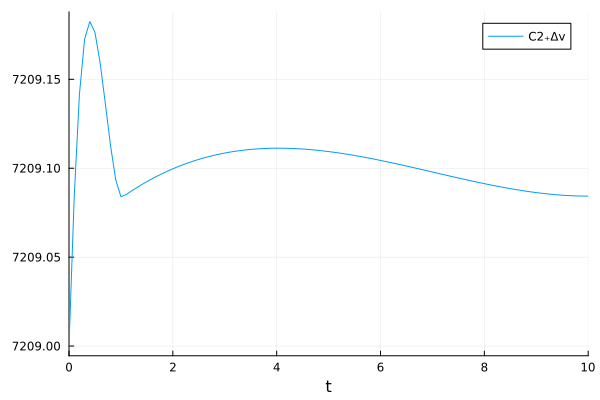

In [16]:
plot(sol2, idxs=[sys.C2.Δv])

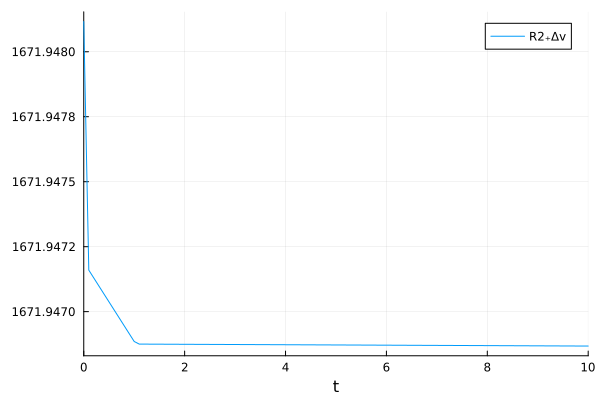

In [17]:
plot(sol2, idxs=[sys.R2.Δv])